**Table of contents**<a id='toc0_'></a>    
- 1. [Problem 1: Production economy and CO2 taxation](#toc1_)    
- 2. [Problem 2: Career choice model](#toc2_)    
- 3. [Problem 3: Barycentric interpolation](#toc3_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [2]:
# Autoreload modules when code is run. Otherwise python will not reload the modules and changes will not be effective.
%load_ext autoreload
%autoreload 2

# Import of required packages
import numpy as np
from types import SimpleNamespace
from scipy.optimize import minimize_scalar, minimize
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import norm


plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.30","grid.linestyle":"--"})
plt.rcParams.update({'font.size': 12})

# In some parts of the exercise, we used copolit for sujesttions and help - especially in Problem 2.3. 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. <a id='toc1_'></a>[Problem 1: Production economy and CO2 taxation](#toc0_)

Consider a production economy with two firms indexed by $j \in \{1,2\}$. Each produce its own good. They solve

$$
\begin{align*}
\max_{y_{j}}\pi_{j}&=p_{j}y_{j}-w_{j}\ell_{j}\\\text{s.t.}\;&y_{j}=A\ell_{j}^{\gamma}.
\end{align*}
$$

Optimal firm behavior is

$$
\begin{align*}
\ell_{j}^{\star}(w,p_{j})&=\left(\frac{p_{j}A\gamma}{w}\right)^{\frac{1}{1-\gamma}} \\
y_{j}^{\star}(w,p_{j})&=A\left(\ell_{j}^{\star}(w,p_{j})\right)^{\gamma}
\end{align*}
$$

The implied profits are

$$
\pi_{j}^*(w,p_{j})=\frac{1-\gamma}{\gamma}w\cdot\left(\frac{p_{j}A\gamma}{w}\right)^{\frac{1}{1-\gamma}}
$$

A single consumer supplies labor, and consumes the goods the firms produce. She also recieves the implied profits of the firm.<br>
She solves:

$$
\begin{align*}
U(p_1,p_2,w,\tau,T) = \max_{c_{1},c_{2},\ell} & \log(c_{1}^{\alpha}c_{2}^{1-\alpha})-\nu\frac{\ell^{1+\epsilon}}{1+\epsilon} \\
\text{s.t.}\,\,\,&p_{1}c_{1}+(p_{2}+\tau)c_{2}=w\ell+T+\pi_{1}^*(w,p_{1})+\pi_{2}^*(w,p_{2})
\end{align*}
$$

where $\tau$ is a tax and $T$ is lump-sum transfer. <br>
For a given $\ell$, it can be shown that optimal behavior is

$$
\begin{align*}
c_{1}(\ell)&=\alpha\frac{w\ell+T+\pi_{1}^*(w,p_{1})+\pi_{2}^*(w,p_{2})}{p_{1}} \\
c_{2}(\ell)&=(1-\alpha)\frac{w\ell+T+\pi_{1}^*(w,p_{1})+\pi_{2}^*(w,p_{2})}{p_{2}+\tau} \\
\end{align*}
$$
Such that optimal behavior is:
$$
\ell^* = \underset{\ell}{\arg\max} \log(\left(c_{1}(\ell)\right)^{\alpha}\cdot \left(c_{2}(\ell)\right)^{1-\alpha})-\nu\frac{\ell^{1+\epsilon}}{1+\epsilon} 
$$
With optimal consumption:
$$
\begin{align*}
c_1^*=c_{1}(\ell^*) \\
c_2^*=c_{2}(\ell^*)\\
\end{align*}
$$


The government chooses $\tau$ and balances its budget so $T=\tau c_2^*$. We initially set $\tau,T=0$.

Market clearing requires:

1. Labor market: $\ell^* = \ell_1^* + \ell_2^*$
1. Good market 1: $c_1^* = y_1^*$
1. Good market 2: $c_2^* = y_2^*$


In [4]:
# The first part defines the functions and parameters that are described in the Problem

# Define parameters
par = SimpleNamespace()
par.A = 1.0
par.gamma = 0.5
par.alpha = 0.3
par.nu = 1.0
par.epsilon = 2.0
par.tau = 0.0
par.T = 0.0
par.kappa = 0.1
par.w = 1.0
w = 1.0

# Define firm's optimal labor supply and output functions
def firm_labor_supply(pj, w, A, gamma): 
    return (pj * A * gamma / w) ** (1 / (1 - gamma)) 

def firm_output(lj, A, gamma):
    return A * (lj ** gamma)

# Define firm's profit function
def firm_profits(pj, w, lj, A, gamma):
    return pj * firm_output(lj, A, gamma) - w * lj

# Define consumer's optimal consumption functions
def c1(wl, T, pi1, pi2, alpha, p1):
    return alpha * (wl + T + pi1 + pi2) / p1

def c2(wl, T, pi1, pi2, alpha, p2, tau):
    return (1 - alpha) * (wl + T + pi1 + pi2) / (p2 + tau)

# Define the utility maximization function
def utility_maximization(l, par, p1, p2, w, tau, T):
    lj1 = firm_labor_supply(p1, w, par.A, par.gamma)
    lj2 = firm_labor_supply(p2, w, par.A, par.gamma)
    y1 = firm_output(lj1, par.A, par.gamma)
    y2 = firm_output(lj2, par.A, par.gamma)
    pi1 = firm_profits(p1, w, lj1, par.A, par.gamma)
    pi2 = firm_profits(p2, w, lj2, par.A, par.gamma)
    
    c1_opt = c1(w * l, T, pi1, pi2, par.alpha, p1)
    c2_opt = c2(w * l, T, pi1, pi2, par.alpha, p2, tau)
    
    return np.log(c1_opt ** par.alpha * c2_opt ** (1 - par.alpha)) - par.nu * (l ** (1 + par.epsilon)) / (1 + par.epsilon)

# Find optimal labor supply
def find_optimal_l(par, p1, p2, w, tau, T):
    res = minimize_scalar(lambda l: -utility_maximization(l, par, p1, p2, w, tau, T), bounds=(0, 10), method='bounded')
    return res.x

# Excess demand functions
def excess_demand(p1, p2, par, w):
    l_opt = find_optimal_l(par, p1, p2, w, par.tau, par.T)
    lj1 = firm_labor_supply(p1, w, par.A, par.gamma)
    lj2 = firm_labor_supply(p2, w, par.A, par.gamma)
    y1 = firm_output(lj1, par.A, par.gamma)
    y2 = firm_output(lj2, par.A, par.gamma)
    pi1 = firm_profits(p1, w, lj1, par.A, par.gamma)
    pi2 = firm_profits(p2, w, lj2, par.A, par.gamma)
    
    c1_opt = c1(w * l_opt, par.T, pi1, pi2, par.alpha, p1)
    c2_opt = c2(w * l_opt, par.T, pi1, pi2, par.alpha, p2, par.tau)
    
    ed_good1 = c1_opt - y1
    ed_good2 = c2_opt - y2
    
    return ed_good1, ed_good2

# Objective function to minimize
def objective(params, par, w):
    p1, p2 = params
    ed_good1, ed_good2 = excess_demand(p1, p2, par, w)
    return ed_good1**2 + ed_good2**2

# Parameters for social welfare function
def calculate_economics(tau, par):
    p1, p2 = 1.0, 1.0  # Assume prices are normalized
    l1_star = firm_labor_supply(p1, par.w, par.A, par.gamma)
    l2_star = firm_labor_supply(p2 + tau, par.w, par.A, par.gamma)
    y1_star = firm_output(l1_star, par.A, par.gamma)
    y2_star = firm_output(l2_star, par.A, par.gamma)
    pi1_star = firm_profits(p1, par.w, l1_star, par.A, par.gamma)
    pi2_star = firm_profits(p2 + tau, par.w, l2_star, par.A, par.gamma)
    return l1_star, l2_star, y1_star, y2_star, pi1_star, pi2_star

def swf(tau, par):
    l1_star, l2_star, y1_star, y2_star, pi1_star, pi2_star = calculate_economics(tau, par)
    l_star = l1_star + l2_star
    T = tau * ((1 - par.alpha) * (par.w * l_star + pi1_star + pi2_star) / (1.0 + tau))
    c1_star = par.alpha * (par.w * l_star + T + pi1_star + pi2_star) / 1.0
    c2_star = (1 - par.alpha) * (par.w * l_star + T + pi1_star + pi2_star) / (1.0 + tau)
    U = np.log(c1_star ** par.alpha * c2_star ** (1 - par.alpha)) - par.nu * (l_star ** (1 + par.epsilon)) / (1 + par.epsilon)
    SWF = U - par.kappa * y2_star 
    return -SWF  # Negative because we minimize this in the optimizer

**Question 1:** Check market clearing conditions for $p_1$ in `linspace(0.1,2.0,10)` and $p_2$ in `linspace(0.1,2.0,10)`. We choose $w=1$ as numeraire.

## Question 1.1
To answer question 1 we look at the error in the market clearing condition for all prices of p1 and p2 in `linspace(0.1,2.0,10)`.

We use the following steps to solve this problem: 
1. Define price grids for p1 and p2
2. Initialize excess demand matrices  
3. Compute excess demand - we loop through all combinations of the price grid 
4. Print results 
5. Create 3D plots to illustrate the results

The error in the market clearing condition can also be viewed as the excess demand on all of the 3 markets. For the good market 1 the excess demand for good 1 is the demand for c1 from the consumer minus the supply of y1 from firm 1. Similar, the excess demand on good market 2 is the demand for c2 from the consumer minus the supply of y2 from firm 2. For the labor market the excess demand is the combined demand for labor from firm 1 and 2 minus the supply of labor from the consumer.

We then look at the excess demand on all 3 markets for all the relevant price combinatations of p1 and p2 (with w=1) and print the results. Additionally, we make a 3D visualization of the development in the excess demand for the relevant price combinations. If the excess demand is 0 on a market it means there is market clearing on this market. For the market clearing to hold there need to be 0 excess demand on all 3 markets at the same time.

Note that we use "linespace(0.1,2.0,10)" which creates 10 numbers evenly spaced in the interval 0.1-2.0. Thus, the distance between each point is $\frac{2.0-1.0}{10-1}$=0.21. This explains why the first price we check for is $(p_1,p_2)=(0.1,0.1)$ and then we increase $p_1$ with 0.21 to 0.31 to look at $(p_1,p_2)=(0.31,0.1)$. Similarly we increase  $p_2$ with 0.21 to 0.31 to look at $(p_1,p_2)=(0.31,0.31)$. We continue this way untill we have checked all 100 combinations and use them to make the 3D-plots.

In question 2 we find the combination of prices that clears all 3 markets. However, one must be aware that the combination in question 2 is not part of the points in linespace since these are discrete value and we check for the continous numbers to find a more correct solution that set clears all markets perfectly.


Excess Demand for Goods and Labor:
p1=0.10, p2=0.10 -> Excess Demand for Good 1: 2.9600, Excess Demand for Good 2: 6.9734, Excess Demand for Labor: -0.9933
p1=0.10, p2=0.31 -> Excess Demand for Good 1: 3.0036, Excess Demand for Good 2: 2.1347, Excess Demand for Labor: -0.9645
p1=0.10, p2=0.52 -> Excess Demand for Good 1: 3.0930, Excess Demand for Good 2: 1.1432, Excess Demand for Labor: -0.9063
p1=0.10, p2=0.73 -> Excess Demand for Good 1: 3.2299, Excess Demand for Good 2: 0.6770, Excess Demand for Labor: -0.8194
p1=0.10, p2=0.94 -> Excess Demand for Good 1: 3.4171, Excess Demand for Good 2: 0.3844, Excess Demand for Labor: -0.7047
p1=0.10, p2=1.16 -> Excess Demand for Good 1: 3.6576, Excess Demand for Good 2: 0.1709, Excess Demand for Labor: -0.5632
p1=0.10, p2=1.37 -> Excess Demand for Good 1: 3.9548, Excess Demand for Good 2: 0.0004, Excess Demand for Labor: -0.3961
p1=0.10, p2=1.58 -> Excess Demand for Good 1: 4.3124, Excess Demand for Good 2: -0.1438, Excess Demand for Labor: -0.2

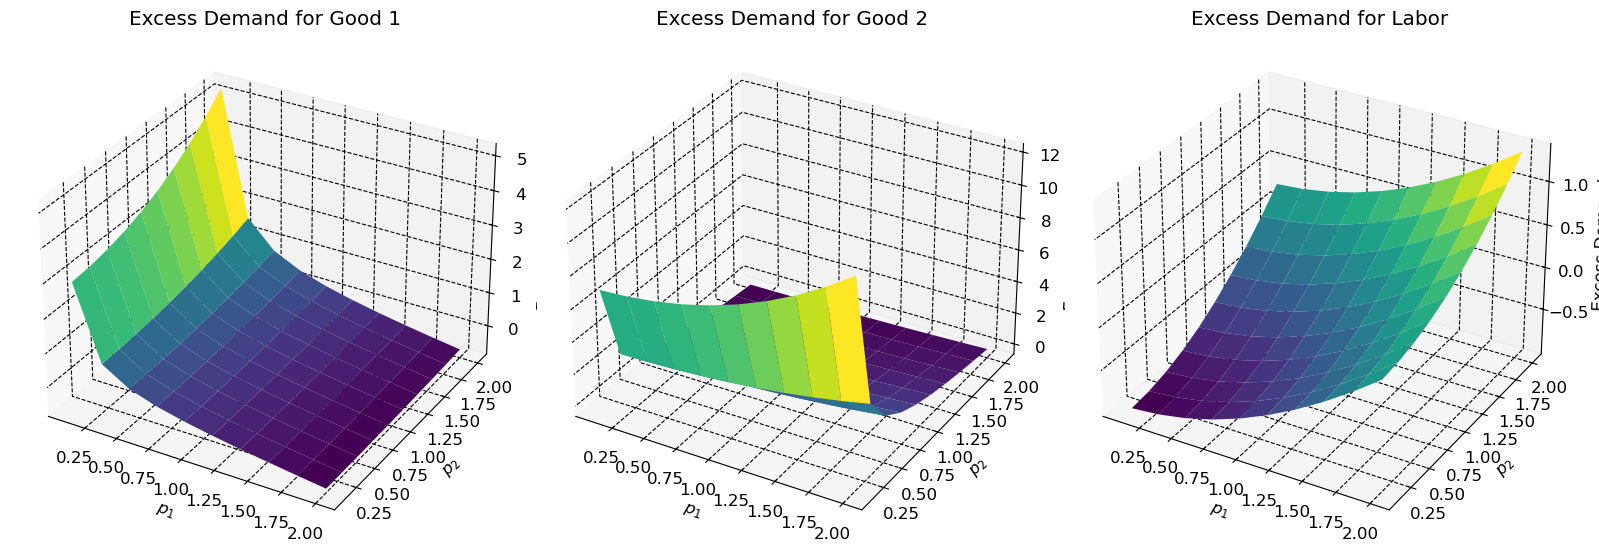

In [5]:
# Check market clearing conditions
p1_values = np.linspace(0.1, 2.0, 10) # Define a grid of the prices for good 1
p2_values = np.linspace(0.1, 2.0, 10) # Define a grid of the prices for good 2

excess_demand_good1 = np.zeros((len(p1_values), len(p2_values))) # The excess demand for good 1
excess_demand_good2 = np.zeros((len(p1_values), len(p2_values))) # The excess demand for good 2
excess_demand_labor = np.zeros((len(p1_values), len(p2_values))) # The excess demand for on the labor market

results = []

for i, p1 in enumerate(p1_values): # Loop over the prices for good 1
    for j, p2 in enumerate(p2_values): # Loop over the prices for good 2
        l_opt = find_optimal_l(par, p1, p2, par.w, par.tau, par.T)
        lj1 = firm_labor_supply(p1, par.w, par.A, par.gamma)
        lj2 = firm_labor_supply(p2, par.w, par.A, par.gamma)
        y1 = firm_output(lj1, par.A, par.gamma)
        y2 = firm_output(lj2, par.A, par.gamma)
        pi1 = firm_profits(p1, par.w, lj1, par.A, par.gamma)
        pi2 = firm_profits(p2, par.w, lj2, par.A, par.gamma)
            
        c1_opt = c1(par.w * l_opt, par.T, pi1, pi2, par.alpha, p1)
        c2_opt = c2(par.w * l_opt, par.T, pi1, pi2, par.alpha, p2, par.tau)
            
        excess_demand_good1[i, j] = c1_opt - y1
        excess_demand_good2[i, j] = c2_opt - y2
        excess_demand_labor[i, j] = (lj1 + lj2) - l_opt
            
        results.append((p1, p2, excess_demand_good1[i, j], excess_demand_good2[i, j], excess_demand_labor[i, j]))

    # Print results
print("Excess Demand for Goods and Labor:")
for p1, p2, ed_g1, ed_g2, ed_l in results:
    print(f"p1={p1:.2f}, p2={p2:.2f} -> Excess Demand for Good 1: {ed_g1:.4f}, Excess Demand for Good 2: {ed_g2:.4f}, Excess Demand for Labor: {ed_l:.4f}")

# Create 3D plots
p1_grid, p2_grid = np.meshgrid(p1_values, p2_values)

fig = plt.figure(figsize=(16, 6))

# Excess Demand for Good 1
ax1 = fig.add_subplot(131, projection='3d')
ax1.plot_surface(p1_grid, p2_grid, excess_demand_good1.T, cmap='viridis')
ax1.set_title('Excess Demand for Good 1')
ax1.set_xlabel('$p_1$')
ax1.set_ylabel('$p_2$')
ax1.set_zlabel('Excess Demand')

# Excess Demand for Good 2
ax2 = fig.add_subplot(132, projection='3d')
ax2.plot_surface(p1_grid, p2_grid, excess_demand_good2.T, cmap='viridis')
ax2.set_title('Excess Demand for Good 2')
ax2.set_xlabel('$p_1$')
ax2.set_ylabel('$p_2$')
ax2.set_zlabel('Excess Demand')

# Excess Demand for Labor
ax3 = fig.add_subplot(133, projection='3d')
ax3.plot_surface(p1_grid, p2_grid, excess_demand_labor.T, cmap='viridis')
ax3.set_title('Excess Demand for Labor')
ax3.set_xlabel('$p_1$')
ax3.set_ylabel('$p_2$')
ax3.set_zlabel('Excess Demand')

plt.tight_layout()
plt.show()

## Question 1.2

**Question 2:** Find the equilibrium prices $p_1$ and $p_2$.<br>
*Hint: you can use Walras' law to only check 2 of the market clearings*

We use the following steps to solve this problem: 
1. We define our inital guess for p1 and p2.
2. We minimize the objevtive function
3. Extract equilibrium prices
4. We print equilibrium prices
5. We verify excess demand at the prices is clearing. 


In [6]:
# Question 2:
# Initial guess for p1 and p2
initial_guess = [1.0, 1.0]

# Minimize the objective function
result = minimize(objective, initial_guess, args=(par, par.w), bounds=[(0.1, 2.0), (0.1, 2.0)], method='L-BFGS-B')
p1_eq, p2_eq = result.x

# Print equilibrium prices
print(f"Equilibrium prices: p1 = {p1_eq:.2f}, p2 = {p2_eq:.2f}")

# Verify excess demands at equilibrium prices
ed_good1_eq, ed_good2_eq = excess_demand(p1_eq, p2_eq, par, par.w)
print(f"Excess demand at equilibrium: Good 1 = {ed_good1_eq:.2f}, Good 2 = {ed_good2_eq:.2f}")


Equilibrium prices: p1 = 0.98, p2 = 1.49
Excess demand at equilibrium: Good 1 = -0.00, Good 2 = -0.00


#### Commenting on the equilibrium price set

We have found that the equlilibrium price set is given by $(p_1^*, p_2^*, w^*)$ = (0.98, 1.49, 1.00). Above we have shown that these prices set the excess demand on the market for good 1 and 2 equal to 0. Thus, from Walras' law it follows that the labor market also clears for this price set. We note that this price set is not part of the prices we checked for in linespace for question 1. This is because the linespace only checked for discrete values, whereas the optimizer used in question 2 solves continously to find the perfect market clearing price set.

#### Checking that Walras' law ensures clearing of the labor market

Below here we show that the labor market also clear for equilibrium price set as predicted by the Walrasian law.

In [7]:
# Verify excess demand on the labor market
l_opt = find_optimal_l(par, p1_eq, p2_eq, par.w, par.tau, par.T) 
lj1 = firm_labor_supply(p1_eq, par.w, par.A, par.gamma) 
lj2 = firm_labor_supply(p2_eq, par.w, par.A, par.gamma)
ed_labor_eq = (lj1 + lj2) - l_opt
print(f"Excess demand at equilibrium: Labor = {ed_labor_eq:.2f}")

Excess demand at equilibrium: Labor = 0.00


## Question 1.3

Assume the government care about the social welfare function:

$$
SWF = U - \kappa y_2^*
$$

Here $\kappa$ measures the social cost of carbon emitted by the production of $y_2$ in equilibrium.

**Question 3:** What values of $\tau$ and (implied) $T$ should the government choose to maximize $SWF$?

In solving this we use the following steps
1. Set up the optimization problem
2. Perform the optimization
3. Calculate equilibrium
4. Determine the optimal lump-sum transfer 
5. Output the results

In [8]:
# Optimization to find the optimal tau
result = minimize_scalar(swf, args=(par,), bounds=(0, 1), method='bounded')
optimal_tau = result.x
l1_star, l2_star, y1_star, y2_star, pi1_star, pi2_star = calculate_economics(optimal_tau, par)
optimal_T = optimal_tau * ((1 - par.alpha) * (par.w * (l1_star + l2_star) + pi1_star + pi2_star) / (1.0 + optimal_tau))

# Output the results
print(f"Optimal tau: {optimal_tau:.2f}")
print(f"Implied optimal T: {optimal_T:.2f}")

Optimal tau: 0.60
Implied optimal T: 0.46


#### Intuitive Explanation of the Optimal Tax and Transfer:

**Optimal Tax on Good 2 ($\tau^*$):**

In the economic model, the optimal tax rate $\tau^* = 0.60$ is higher than the marginal cost of the externality $\kappa = 0.10$. This result shows that the optimal tax must account for more than just the externality cost.

**Key factors influencing the higher optimal tax rate:**

- Behavioral Adjustment: The tax impacts consumer behavior. Since the utility function considers the consumption of both goods, changing $\tau$ affects overall utility. A higher tax rate may be needed to guide consumption towards a balance that maximizes overall welfare, considering both private and external costs.

- Revenue for Redistribution: The tax revenue funds a transfer $T$, which balances the government's budget. The tax must be high enough to support this transfer, which mitigates the tax's negative effects on consumer welfare and maintains economic stability.

- Market Equilibrium Considerations: The tax affects labor allocation and production outputs. Optimal taxation must consider these general equilibrium effects, aiming to balance production incentives, labor market adjustments, and consumption patterns.

**Implications of the Transfer ($T$):**

The transfer $T = 0.46$ uses the tax revenues from $\tau^*$ to support consumer welfare. While the tax raises the price and reduces consumption of the taxed good, $T$ helps consumers maintain their purchasing power and living standards.

## 2. <a id='toc2_'></a>[Problem 2: Career choice model](#toc0_)

Consider a graduate $i$ making a choice between entering $J$ different career tracks. <br>
Entering career $j$ yields utility $u^k_{ij}$. This value is unknown to the graduate ex ante, but will ex post be: <br>
$$
    u_{i,j}^k = v_{j} + \epsilon_{i,j}^k
$$

They know that $\epsilon^k_{i,j}\sim \mathcal{N}(0,\sigma^2)$, but they do not observe $\epsilon^k_{i,j}$ before making their career choice. <br>

Consider the concrete case of $J=3$ with:
$$
\begin{align*}
    v_{1} &= 1 \\
    v_{2} &= 2 \\
    v_{3} &= 3
\end{align*}
$$

If the graduates know the values of $v_j$ and the distribution of $\epsilon_{i,j}^k$, they can calculate the expected utility of each career track using simulation: <br>
$$
    \mathbb{E}\left[ u^k_{i,j}\vert v_j \right] \approx v_j + \frac{1}{K}\sum_{k=1}^K \epsilon_{i,j}^k
$$

In [9]:
par = SimpleNamespace()
par.J = 3
par.N = 10
par.K = 10000

par.F = np.arange(1,par.N+1)
par.sigma = 2

par.v = np.array([1,2,3])
par.c = 1

# Question 2.1

**Question 1:** Simulate and calculate expected utility and the average realised utility for $K=10000$ draws, for each career choice $j$.

In this problem, we simulate the expected and realized utilities of graduates choosing between different career tracks. 
Each career track has an associated utility, which is influenced by randomness. 
We aim to compare the calculated expected utility with the simulated average realized utility for each career track.

We use the following steps in solving the Problem
1. Set a seed 
2. Define utility simulation function 
3. Calculate expected and realized utilities 
4. Generate a random sample for realized utilities 
5. We run the simulation
6. output the results 
7. Plot bar chart and texst+labels 
8. Display the chart

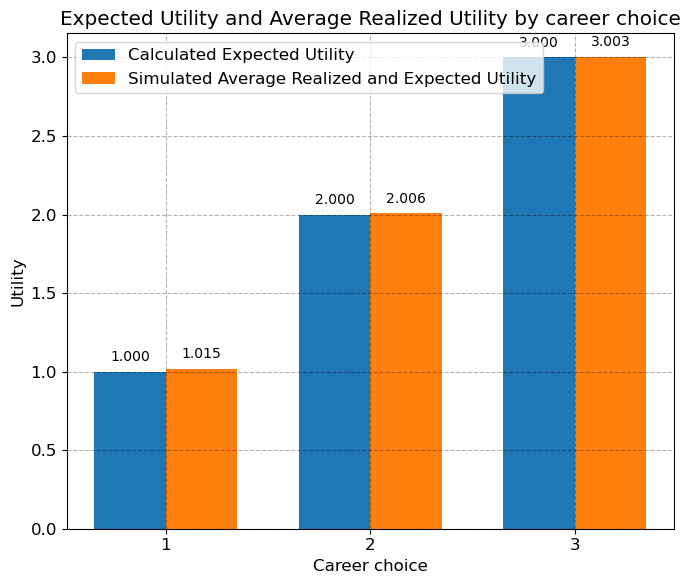

In [10]:
# We set the seed for reproducibility
seed = 2024
rng = np.random.RandomState(seed)

# Function to calculate expected and realized utilities
def simulate_utilities(par, rng):
    expected_utilities = par.v  # Expected utility should be just v_j
    realized_utilities = np.zeros(par.J) # we define an array to store the realized utilities for each career track

    for j in range(par.J):
        # Generate K samples from the normal distribution for epsilon
        epsilon_samples = rng.normal(0, par.sigma, par.K)
        
        # Calculate realized utility for each sample
        realized_utilities[j] = par.v[j] + epsilon_samples.mean()
    
    return expected_utilities, realized_utilities

# Run the simulation
expected_utilities, realized_utilities = simulate_utilities(par, rng)

# Output the results
results = []
for j in range(par.J):
    results.append({
        "Career Track": j + 1,
        "Expected Utility": expected_utilities[j],
        "Average Realized Utility": realized_utilities[j]
    })

# Prepare data for bar chart
career_tracks = [result["Career Track"] for result in results]
expected_utilities = [result["Expected Utility"] for result in results]
realized_utilities = [result["Average Realized Utility"] for result in results]

# Plot bar chart
fig, ax = plt.subplots(figsize=(7, 6))
bar_width = 0.35
index = np.arange(len(career_tracks))

bar1 = ax.bar(index, expected_utilities, bar_width, label='Calculated Expected Utility')
bar2 = ax.bar(index + bar_width, realized_utilities, bar_width, label='Simulated Average Realized and Expected Utility')

ax.set_xlabel('Career choice')
ax.set_ylabel('Utility')
ax.set_title('Expected Utility and Average Realized Utility by career choice')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(career_tracks)
ax.legend()

# Add text labels with values
for i in range(len(career_tracks)):
    ax.text(i, expected_utilities[i] + 0.05, f'{expected_utilities[i]:.3f}', ha='center', va='bottom', fontsize=10)
    ax.text(i + bar_width, realized_utilities[i] + 0.05, f'{realized_utilities[i]:.3f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

### Commenting on the calculated expected utility and simulated average realized utility
**The calculated expected utility**

We find that the expected utility is equal to 1, 2 and 3 for career choice 1, 2 and 3. This makes sense, since the expected value of $\varepsilon$ is equal to 0 given it is normally distributed with a mean of 0.

**The simulated average realized utility**

We see that the average realized utility is close to the expected utility. This makes sense as well, since the average realized utility will converge towards the expcted utility when K goes towards inifity and we have a fairly large K at 10.000 draws in the simulation. The reason is that the law of large numbers will make the draws of $\varepsilon$ converge to it's true distribution for a sufficiently large K which will give $\varepsilon$ of 0 on average just like in the expectation.

# Question 2.2

Now consider a new scenario: Imagine that the graduate does not know $v_j$. The *only* prior information they have on the value of each job, comes from their $F_{i}$ friends that work in each career $j$. After talking with them, they know the average utility of their friends (which includes their friends' noise term), giving them the prior expecation: <br>
$$
\tilde{u}^k_{i,j}\left( F_{i}\right) = \frac{1}{F_{i}}\sum_{f=1}^{F_{i}} \left(v_{j} + \epsilon^k_{f,j}\right), \; \epsilon^k_{f,j}\sim \mathcal{N}(0,\sigma^2)
$$
For ease of notation consider that each graduate have $F_{i}=i$ friends in each career. <br>

For $K$ times do the following: <br>
1. For each person $i$ draw $J\cdot F_i$ values of $\epsilon_{f,j}^{k}$, and calculate the prior expected utility of each career track, $\tilde{u}^k_{i,j}\left( F_{i}\right)$. <br>
Also draw their own $J$ noise terms, $\epsilon_{i,j}^k$
1. Each person $i$ chooses the career track with the highest expected utility: $$j_i^{k*}= \arg\max_{j\in{1,2\dots,J}}\left\{ \tilde{u}^k_{i,j}\left( F_{i}\right)\right\} $$
1. Store the chosen careers: $j_i^{k*}$, the prior expectation of the value of their chosen career: $\tilde{u}^k_{i,j=j_i^{k*}}\left( F_{i}\right)$, and the realized value of their chosen career track: $u^k_{i,j=j_i^{k*}}=v_{j=j_i^{k*}}+\epsilon_{i,j=j_i^{k*}}^k$.

Chosen values will be: <br>
$i\in\left\{1,2\dots,N\right\}, N=10$ <br>
$F_i = i$<br>
So there are 10 graduates. The first has 1 friend in each career, the second has 2 friends, ... the tenth has 10 friends.

**Question 2:** Simulate and visualize: For each type of graduate, $i$, the share of graduates choosing each career, the average subjective expected utility of the graduates, and the average ex post realized utility given their choice. <br>
That is, calculate and visualize: <br>
$$
\begin{align*}
    \frac{1}{K} \sum_{k=1}^{K} \mathbb{I}\left\{ j=j_i^{k*} \right\}  \;\forall j\in\left\{1,2,\dots,J\right\}
\end{align*}
$$
$$
\begin{align*}
    \frac{1}{K} \sum_{k=1}^{K} \tilde{u}^k_{ij=j_i^{k*}}\left( F_{i}\right)
\end{align*}
$$
And 
$$
\begin{align*}
    \frac{1}{K} \sum_{k=1}^{K} u^k_{ij=j_i^{k*}} 
\end{align*}
$$
For each graduate $i$.

In this problem, we simulate the career choices of graduates who have varying amounts of information about the utilities of different career tracks. We aim to visualize the share of graduates choosing each career, the average subjective expected utility, and the average realized utility for each graduate type.

Steps in solving:
1. Define the functions used to simulate career choices and utilities (With a loop over K simlations)
2. Initialize storage for results 
3. run simulations
4. calculate the prior expected and realized utilities 
5. choose best career track 
6. normalize the results
7. run the sumulation 
8. plot the results

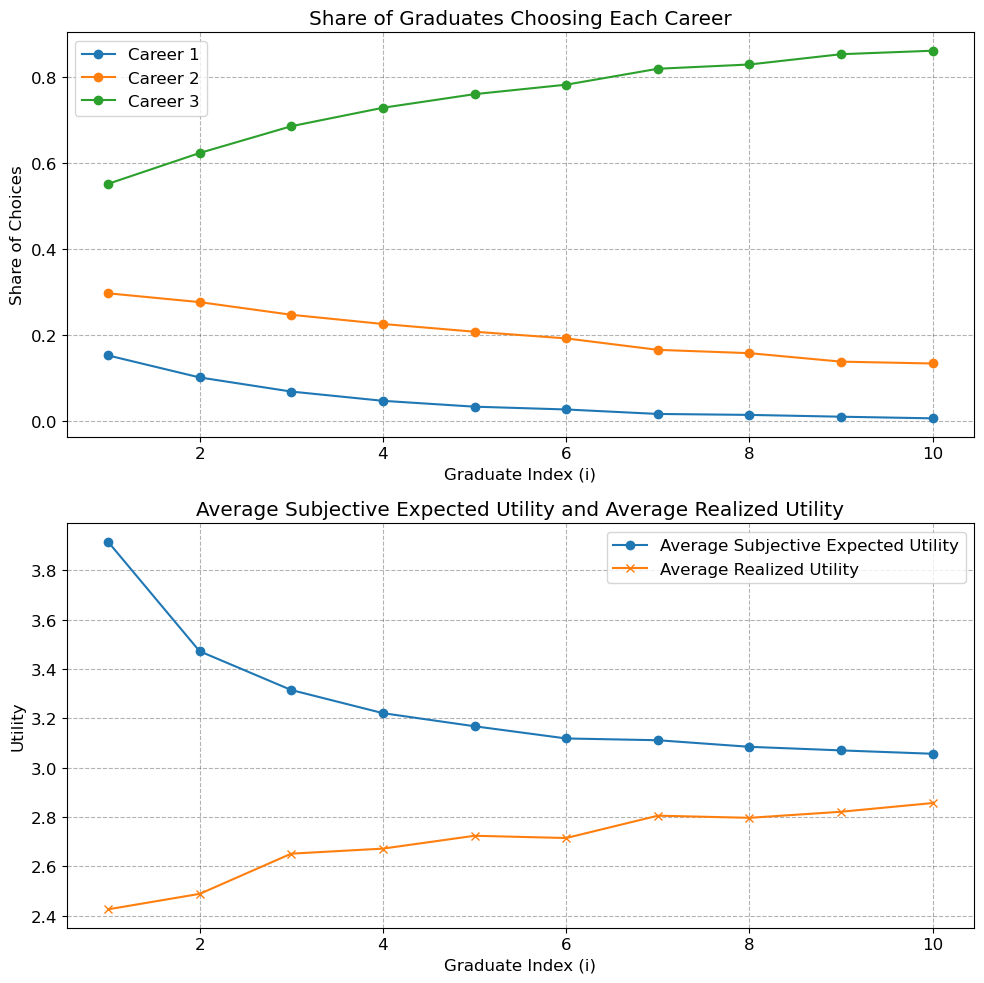

In [11]:
# Define functions used to simulate career chories and utilities 
def simulate_career_choices(par, rng):
    share_choices = np.zeros((par.N, par.J)) # Array to store share of choices for each career track
    avg_subjective_utility = np.zeros(par.N) # Array to store average subjective utility for each graduate
    avg_realized_utility = np.zeros(par.N)  # Array to store average realized utility for each graduate

    for k in range(par.K): # Loop over K simulations
        for i in range(par.N): # Loop over N graduates
            F_i = par.F[i] 
            prior_expected_utilities = np.zeros(par.J) 
            realized_utilities = np.zeros(par.J)
            epsilon_i = rng.normal(0, par.sigma, par.J)
            
            for j in range(par.J):
                epsilon_friends = rng.normal(0, par.sigma, F_i) # Generate F_i samples from the normal distribution for epsilon
                prior_expected_utilities[j] = par.v[j] + epsilon_friends.mean() # Calculate prior expected utility for each career track
                realized_utilities[j] = par.v[j] + epsilon_i[j] # Calculate realized utility for each career track
            
            best_career = np.argmax(prior_expected_utilities) # Find the career track with the highest prior expected utility
            share_choices[i, best_career] += 1
            avg_subjective_utility[i] += prior_expected_utilities[best_career]
            avg_realized_utility[i] += realized_utilities[best_career]

    share_choices /= par.K # Normalize the share of choices
    avg_subjective_utility /= par.K # Normalize the average subjective utility
    avg_realized_utility /= par.K # Normalize the average realized utility

    return share_choices, avg_subjective_utility, avg_realized_utility

# Run the simulation
share_choices, avg_subjective_utility, avg_realized_utility = simulate_career_choices(par, rng)

# Plotting the results
fig, ax = plt.subplots(2, 1, figsize=(10, 10))

# Share of graduates choosing each career
for j in range(par.J):
    ax[0].plot(par.F, share_choices[:, j], marker='o', label=f'Career {j+1}')
ax[0].set_title('Share of Graduates Choosing Each Career')
ax[0].set_xlabel('Graduate Index (i)')
ax[0].set_ylabel('Share of Choices')
ax[0].legend()

# Combined plot for average subjective expected utility and average realized utility
ax[1].plot(par.F, avg_subjective_utility, marker='o', label='Average Subjective Expected Utility')
ax[1].plot(par.F, avg_realized_utility, marker='x', label='Average Realized Utility')
ax[1].set_title('Average Subjective Expected Utility and Average Realized Utility')
ax[1].set_xlabel('Graduate Index (i)')
ax[1].set_ylabel('Utility')
ax[1].legend()

plt.tight_layout()
plt.show()

#### Share of Graduates Choosing Each Career
The first plot shows the share of graduates choosing each career as the number of friends (graduate index \(i\)) increases:

- **Career 1 (blue)**: Decreases as the number of friends increases, indicating less attractiveness with more information.
- **Career 2 (orange)**: Remains relatively stable with a slight decrease.
- **Career 3 (green)**: Increases significantly, suggesting more attractiveness with more information from friends.

#### Average Subjective Expected Utility and Average Realized Utility
The second plot shows:

- **Average Subjective Expected Utility (blue)**: Decreases with more friends, indicating more realistic expectations.
- **Average Realized Utility (orange)**: Increases with more friends, showing better-informed decisions and higher actual utility.

In summary, more friends provide better information, leading to improved career choices and higher realized utility, particularly for Career 3.


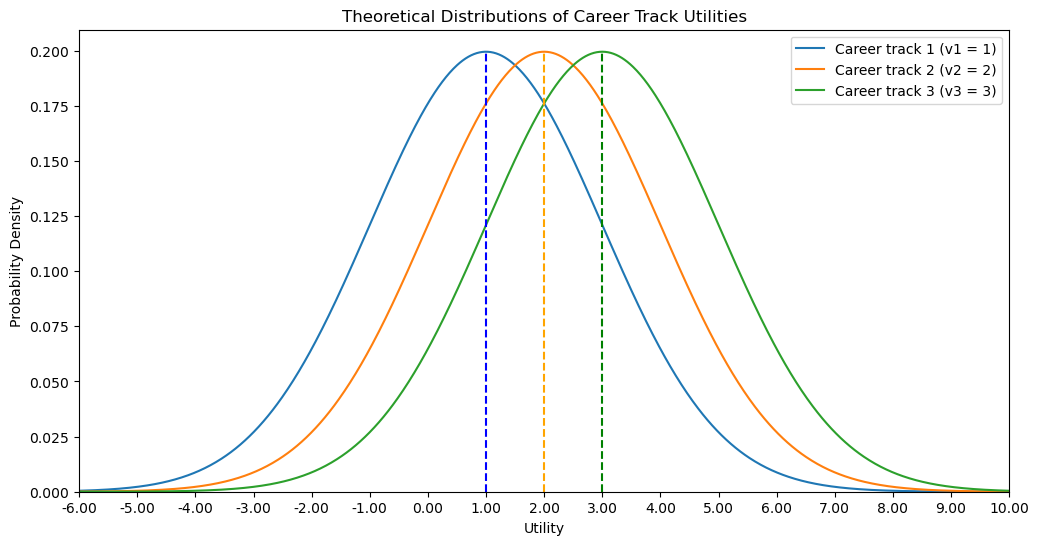

In [11]:
# Given parameters
v = np.array([1, 2, 3])
sigma = 2

# Define the range for the x-axis
x = np.linspace(-6, 10, 1000)

# Calculate the PDFs for each career track
pdf_v1 = norm.pdf(x, loc=v[0], scale=sigma)
pdf_v2 = norm.pdf(x, loc=v[1], scale=sigma)
pdf_v3 = norm.pdf(x, loc=v[2], scale=sigma)

# Plot the PDFs
plt.figure(figsize=(12, 6))
plt.plot(x, pdf_v1, label='Career track 1 (v1 = 1)')
plt.plot(x, pdf_v2, label='Career track 2 (v2 = 2)')
plt.plot(x, pdf_v3, label='Career track 3 (v3 = 3)')

# Add dashed lines at the means
plt.axvline(v[0], color='blue', linestyle='--', ymax=0.95)
plt.axvline(v[1], color='orange', linestyle='--', ymax=0.95)
plt.axvline(v[2], color='green', linestyle='--', ymax=0.95)

plt.title('Theoretical Distributions of Career Track Utilities')
plt.xlabel('Utility')
plt.ylabel('Probability Density')
plt.legend()

# Set x-axis limits and format
plt.xlim([-6, 10])
plt.xticks(np.arange(-6, 11, 1))
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda val, pos: f'{val:.2f}'))

# Adjust y-axis to start from 0.00
plt.ylim(bottom=0)

plt.show()


### Explanation of High Initial Subjective Expected Utility

The high initial average subjective expected utility arises because graduates initially base their expectations on information from their friends. Since the theoretical distributions of career track utilities have means (\(v_1 = 1\), \(v_2 = 2\), \(v_3 = 3\)), and given that graduates' friends have already chosen career paths with higher average utilities, this skews their initial expectations upwards.

# Question 2.3

After a year of working in their career, the graduates learn $u^k_{ij}$ for their chosen job $j_i^{k*}$ perfectly. <br>
The can switch to one of the two remaining careers, for which they have the same prior as before, but it will now include a switching cost of $c$ which is known.
Their new priors can be written as: 
$$
\tilde{u}^{k,2}_{ij}\left( F_{i}\right) = \begin{cases}
            \tilde{u}^k_{ij}\left( F_{i}\right)-c & \text{if } j \neq j_i^{k*} \\
            u_{ij=j_i^{k*}} & \text{if } j = j_i^{k*}
        \end{cases}
$$

We will set $c=1$.

Their realized utility will be: <br>
$$
u^{k,2}_{ij}= \begin{cases}
            u_{ij}^k -c & \text{if } j \neq j_i^{k*} \\
            u_{ij=j_i^{k*}} & \text{if } j = j_i^{k*}
        \end{cases}
$$

**Question 3:** Following the same approach as in question 2, find the new optimal career choice for each $i$, $k$. Then for each $i$, calculate the average subjective expected utility from their new optimal career choice, and the ex post realized utility of that career. Also, for each $i$, calculate the share of graduates that chooses to switch careers, conditional on which career they chose in the first year. <br>

In this problem, we simulate the scenario where graduates, after gaining experience in their chosen career tracks, have the option to switch to another career with a known switching cost (c=1). We aim to find the new optimal career choices and analyze the resulting utilities and share of graduates switching careers.

Steps used in solving this problem
1. Set the parameter for switching cost 
2. We define functions to simulate carerr switcing and utility 
3. Initialize storage for the results 
4. First round of carrer choice simulation 
5. Store the initial career choices and realized utilities 
6. Second round of career choice simlation with switching cost 
7. Normialze results 
8. Run the sumulation and plot the results

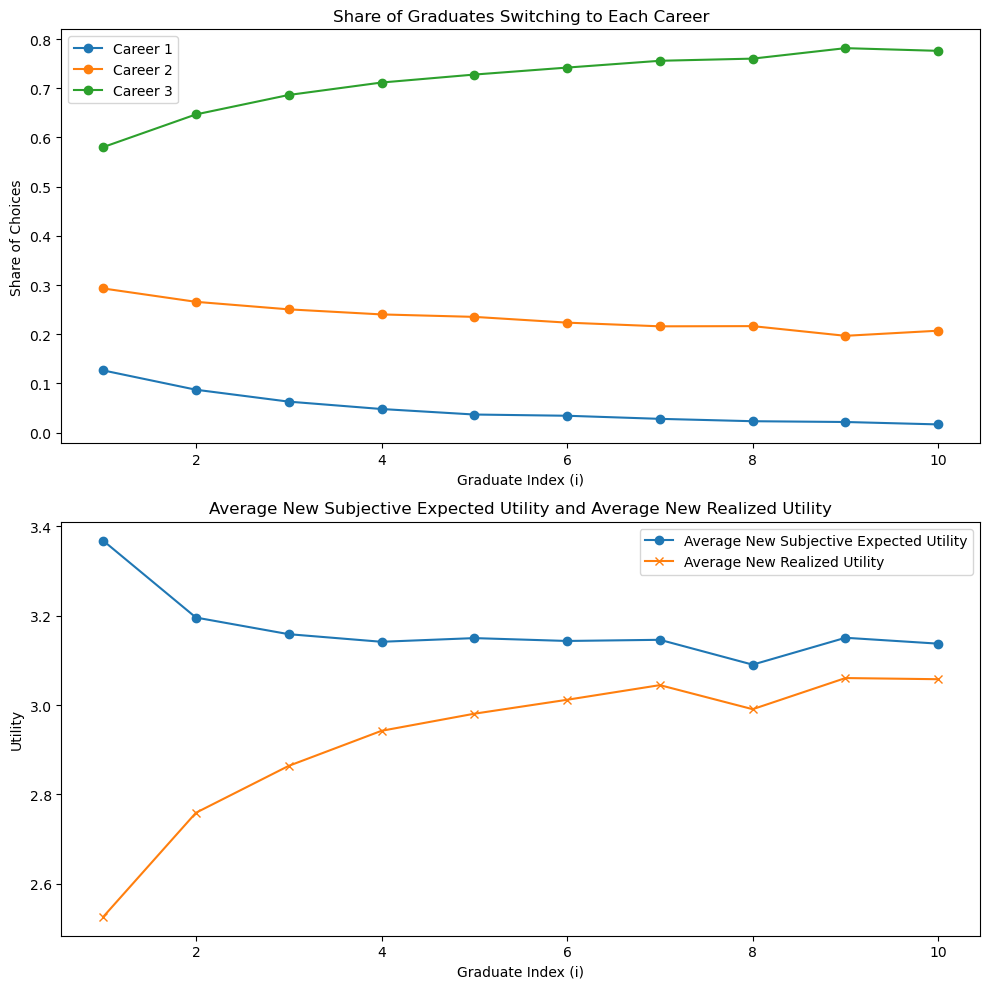

In [12]:



# Parameters for switching cost
par.c = 1

# Function to simulate switching career choices and utilities
def simulate_career_switching(par, rng):
    switch_choices = np.zeros((par.N, par.J))
    avg_new_subjective_utility = np.zeros(par.N)
    avg_new_realized_utility = np.zeros(par.N)

    for k in range(par.K):
        chosen_careers = np.zeros(par.N, dtype=int)
        prior_utilities = np.zeros((par.N, par.J))
        initial_realized_utilities = np.zeros(par.N)
        
        for i in range(par.N):
            F_i = par.F[i]
            prior_expected_utilities = np.zeros(par.J)
            realized_utilities = np.zeros(par.J)
            epsilon_i = rng.normal(0, par.sigma, par.J)
            
            for j in range(par.J):
                epsilon_friends = rng.normal(0, par.sigma, F_i)
                prior_expected_utilities[j] = par.v[j] + epsilon_friends.mean()
                realized_utilities[j] = par.v[j] + epsilon_i[j]
            
            best_career = np.argmax(prior_expected_utilities)
            chosen_careers[i] = best_career
            initial_realized_utilities[i] = realized_utilities[best_career]
        
        for i in range(par.N):
            F_i = par.F[i]
            current_career = chosen_careers[i]
            new_prior_expected_utilities = np.zeros(par.J)
            new_realized_utilities = np.zeros(par.J)
            epsilon_i = rng.normal(0, par.sigma, par.J)
            
            for j in range(par.J):
                if j == current_career:
                    new_prior_expected_utilities[j] = initial_realized_utilities[i]
                    new_realized_utilities[j] = initial_realized_utilities[i]
                else:
                    epsilon_friends = rng.normal(0, par.sigma, F_i)
                    new_prior_expected_utilities[j] = par.v[j] + epsilon_friends.mean() - par.c
                    new_realized_utilities[j] = par.v[j] + epsilon_i[j] - par.c
            
            best_new_career = np.argmax(new_prior_expected_utilities)
            switch_choices[i, best_new_career] += 1
            avg_new_subjective_utility[i] += new_prior_expected_utilities[best_new_career]
            avg_new_realized_utility[i] += new_realized_utilities[best_new_career]

    switch_choices /= par.K
    avg_new_subjective_utility /= par.K
    avg_new_realized_utility /= par.K

    return switch_choices, avg_new_subjective_utility, avg_new_realized_utility

# Run the simulation
switch_choices, avg_new_subjective_utility, avg_new_realized_utility = simulate_career_switching(par, rng)

# Plotting the results
fig, ax = plt.subplots(2, 1, figsize=(10, 10))

# Share of graduates switching to each career
for j in range(par.J):
    ax[0].plot(par.F, switch_choices[:, j], marker='o', label=f'Career {j+1}')
ax[0].set_title('Share of Graduates Switching to Each Career')
ax[0].set_xlabel('Graduate Index (i)')
ax[0].set_ylabel('Share of Choices')
ax[0].legend()

# Combined plot for average new subjective expected utility and average new realized utility
ax[1].plot(par.F, avg_new_subjective_utility, marker='o', label='Average New Subjective Expected Utility')
ax[1].plot(par.F, avg_new_realized_utility, marker='x', label='Average New Realized Utility')
ax[1].set_title('Average New Subjective Expected Utility and Average New Realized Utility')
ax[1].set_xlabel('Graduate Index (i)')
ax[1].set_ylabel('Utility')
ax[1].legend()

plt.tight_layout()
plt.show()

## Commenting on the graphs from question 2.3
After working in their chosen career for a year, graduates have a better understanding of the true utility of their initial choice. This firsthand experience allows them to make more informed decisions about whether to stay in their current career or switch to another one. However, switching careers incurs a cost (\(c = 1\)), which they must factor into their decision-making process.

The intuition behind the decision-making process can be summarized as follows:
1. **Initial Learning:** Graduates learn the true utility of their chosen career after one year.

2. **Consideration of Switching Costs:** Graduates evaluate the potential benefits of switching to another career, subtracting the switching cost from the expected utility of the alternative careers.

3. **Optimal Decision:** Based on the updated expected utilities, graduates choose the career path that maximizes their expected utility, taking into account the switching cost.

## Conclusion for question 2.3

The results from the simulation reveal the following key insights:

1. **Switching Behavior:** The plot showing the share of graduates switching to each career illustrates that graduates are likely to remain in their initial career if the realized utility is relatively high. However, if the realized utility is low, graduates are more inclined to switch careers, despite the switching cost. This behavior indicates that graduates weigh the cost of switching against the potential benefits of moving to a career with higher expected utility.

2. **Utility Comparison:** The combined plot for average new subjective expected utility and average new realized utility shows that both metrics are generally aligned, indicating that graduates are making rational decisions based on their experiences and expectations. The close alignment between subjective and realized utilities suggests effective decision-making.

3. **Impact of Switching Cost:** The presence of a switching cost acts as a deterrent to frequent changes in career paths. Graduates are more likely to switch only if the expected gain from the new career outweighs the cost of switching. This behavior ensures that the decision to switch is justified by a significant expected improvement in utility.

In summary, the simulation highlights the rational behavior of graduates in updating their career choices based on new information and considering the associated costs. The analysis underscores the importance of realistic expectations and the role of switching costs in guiding optimal career decisions.

## 3. <a id='toc3_'></a>[Problem 3: Barycentric interpolation](#toc0_)

**Problem:** We have a set of random points in the unit square,

$$
\mathcal{X} = \{(x_1,x_2)\,|\,x_1\sim\mathcal{U}(0,1),x_2\sim\mathcal{U}(0,1)\}.
$$

For these points, we know the value of some function $f(x_1,x_2)$,

$$
\mathcal{F} = \{f(x_1,x_2) \,|\, (x_1,x_2) \in \mathcal{X}\}.
$$

Now we want to approximate the value $f(y_1,y_2)$ for some  $y=(y_1,y_2)$, where $y_1\sim\mathcal{U}(0,1)$ and $y_2\sim\mathcal{U}(0,1)$.

**Building block I**

For an arbitrary triangle $ABC$ and a point $y$, define the so-called barycentric coordinates as:

$$
\begin{align*}
  r^{ABC}_1 &= \frac{(B_2-C_2)(y_1-C_1) + (C_1-B_1)(y_2-C_2)}{(B_2-C_2)(A_1-C_1) + (C_1-B_1)(A_2-C_2)} \\
  r^{ABC}_2 &= \frac{(C_2-A_2)(y_1-C_1) + (A_1-C_1)(y_2-C_2)}{(B_2-C_2)(A_1-C_1) + (C_1-B_1)(A_2-C_2)} \\
  r^{ABC}_3 &= 1 - r_1 - r_2.
\end{align*}
$$

If $r^{ABC}_1 \in [0,1]$, $r^{ABC}_2 \in [0,1]$, and $r^{ABC}_3 \in [0,1]$, then the point is inside the triangle.

We always have $y = r^{ABC}_1 A + r^{ABC}_2 B + r^{ABC}_3 C$.

**Building block II**

Define the following points:

$$
\begin{align*}
A&=\arg\min_{(x_{1},x_{2})\in\mathcal{X}}\sqrt{\left(x_{1}-y_{1}\right)^{2}+\left(x_{2}-y_{2}\right)^{2}}\text{ s.t. }x_{1}>y_{1}\text{ and }x_{2}>y_{2}\\
B&=\arg\min_{(x_{1},x_{2})\in\mathcal{X}}\sqrt{\left(x_{1}-y_{1}\right)^{2}+\left(x_{2}-y_{2}\right)^{2}}\text{ s.t. }x_{1}>y_{1}\text{ and }x_{2}<y_{2}\\
C&=\arg\min_{(x_{1},x_{2})\in\mathcal{X}}\sqrt{\left(x_{1}-y_{1}\right)^{2}+\left(x_{2}-y_{2}\right)^{2}}\text{ s.t. }x_{1}<y_{1}\text{ and }x_{2}<y_{2}\\
D&=\arg\min_{(x_{1},x_{2})\in\mathcal{X}}\sqrt{\left(x_{1}-y_{1}\right)^{2}+\left(x_{2}-y_{2}\right)^{2}}\text{ s.t. }x_{1}<y_{1}\text{ and }x_{2}>y_{2}.
\end{align*}
$$

**Algorithm:**

1. Compute $A$, $B$, $C$, and $D$. If not possible return `NaN`.
1. If $y$ is inside the triangle $ABC$ return $r^{ABC}_1 f(A) + r^{ABC}_2 f(B) + r^{ABC}_3 f(C)$.
1. If $y$ is inside the triangle $CDA$ return $r^{CDA}_1 f(C) + r^{CDA}_2 f(D) + r^{CDA}_3 f(A)$.
1. Return `NaN`.



In [11]:
# Autoreload modules when code is run. Otherwise python will not reload the modules and changes will not be effective.
%load_ext autoreload
%autoreload 2

# Write your code here
import numpy as np
from types import SimpleNamespace
import matplotlib.pyplot as plt


plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.30","grid.linestyle":"--"})
plt.rcParams.update({'font.size': 12})

**Sample:**

In [12]:
rng = np.random.default_rng(2024)

X = rng.uniform(size=(50,2))
y = rng.uniform(size=(2,))

# Question 3.1

**Questions 1:** Find $A$, $B$, $C$ and $D$. Illustrate these together with $X$, $y$ and the triangles $ABC$ and $CDA$.

In this task, we solve a problem involving random points within a unit square. The goal is to find specific points A, B, C, and D relative to a randomly chosen point y. These points help form triangles ABC and CDA, useful for further analysis.

Steps to Solve the Exercise 
1. Define the model parameters: Set the seed and number of random points. 
2. Create utility functions: Define functions to find points A, B, C, and D. 

A: [0.261 0.436]
B: [0.213 0.274]
C: [0.101 0.28 ]
D: [0.206 0.443]


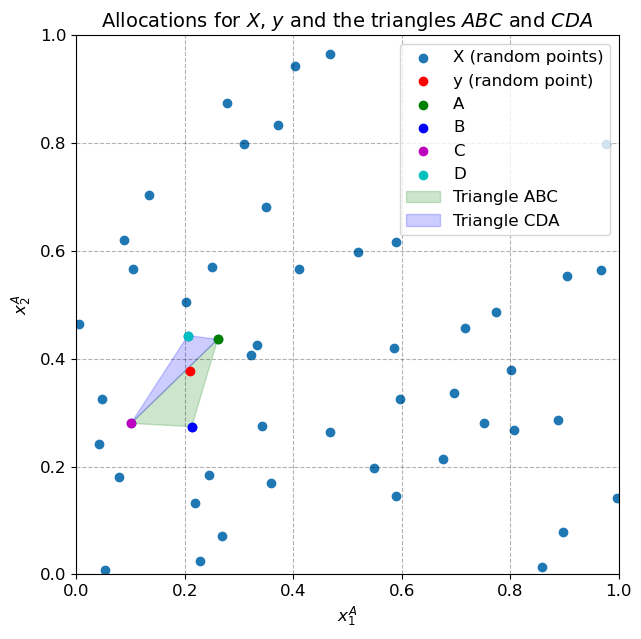

In [13]:
# Import the class from examproject.py
from examproject import Problem3 #

# Create an instance of the Problem 3 class
problem = Problem3()

# Find and print the values for A, B, C, and D
A, B, C, D = problem.find_all_points()
print(f"A: {A}")
print(f"B: {B}")
print(f"C: {C}")
print(f"D: {D}")

# Plot the points and triangles
problem.plot()

# Question 3.2

**Question 2:** Compute the barycentric coordinates of the point $y$ with respect to the triangles $ABC$ and $CDA$. Which triangle is $y$ located inside?

1. Function to compute barycentric coordinates
2. Compute the barycentric coordinates for triangles ABC And CDA
3. Determine which triangle y is inside
4. Print results

In [14]:
# Find the points A, B, C, and D
A, B, C, D = problem.find_all_points() 

# Compute barycentric coordinates of y with respect to triangles ABC and CDA
r_ABC = problem.barycentric_coordinates(problem.y, A, B, C)
r_CDA = problem.barycentric_coordinates(problem.y, C, D, A)

# Determine which triangle y is inside
inside_ABC = problem.is_inside_triangle(r_ABC)
inside_CDA = problem.is_inside_triangle(r_CDA)

# Print results
print(f"Barycentric coordinates of y with respect to triangle ABC: {r_ABC}")
print(f"Barycentric coordinates of y with respect to triangle CDA: {r_CDA}")
print(f"Is y inside triangle ABC? {'Yes' if inside_ABC else 'No'}")
print(f"Is y inside triangle CDA? {'Yes' if inside_CDA else 'No'}")

Barycentric coordinates of y with respect to triangle ABC: (0.631, 0.063, 0.306)
Barycentric coordinates of y with respect to triangle CDA: (0.366, -0.12, 0.754)
Is y inside triangle ABC? Yes
Is y inside triangle CDA? No


Now consider the function:
$$
f(x_1,x_2) = x_1 \cdot x_2
$$

In [15]:
f = lambda x: x[0]*x[1]
F = np.array([f(x) for x in X])

# Question 3.3

**Question 3:** Compute the approximation of $f(y)$ using the full algorithm. Compare with the true value.

Step 1: Define the function to compute the value of f(x).
Step 2: Compute the values of f at points A, B, C, and D. 
Step 3: Compute the barycentric coordinates of y with respect to triangles

Overall, the approximation for the function value f(y) is close to the true value, with only a small difference (0.084 vs. 0.079), indicating a reasonable approximation. 

In [16]:
# Compute the approximation of f(y) and compare with the true value
problem.approximate_f_y()

Approximation of f(y): 0.084
True value of f(y): 0.079


# Question 3.4

**Question 4:** Repeat question 3 for all points in the set $Y$.

In this task, we aim to approcimate the value of a function f at various points within a unit square using a set of randomly generated points. 
The function f is known for a given set of points X, and our goal is to approximate f(y) for new points y using bartcentric coordinates within transgles formed by the points in X.

The steps are the following:
1. Iterating Over Points in Y
2. Plotting Trangles and Points 
3. Computing Function Values and Barycentric Coordinates 
4. Checking Inclusion and Approximation
5. Handling Invalid Points. 


In [17]:
# Define the set Y of points
Y = [(0.2,0.2),(0.8,0.2),(0.8,0.8),(0.8,0.2),(0.5,0.5)]

# Is this not a mistake? The point (0.8,0,2) is defined twice. 

Point y: [0.2 0.2]
Approximation of y (ABC): [0.1999 0.2   ]
Approximation of f(y) (ABC): 0.0403
True value of f(y): 0.04
---


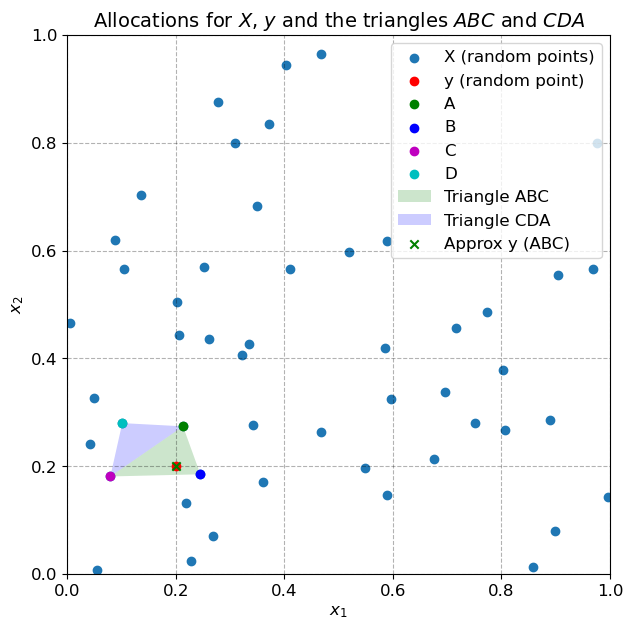

Point y: [0.8 0.2]
Approximation of y (ABC): [0.7999 0.2   ]
Approximation of f(y) (ABC): 0.1587
True value of f(y): 0.16
---


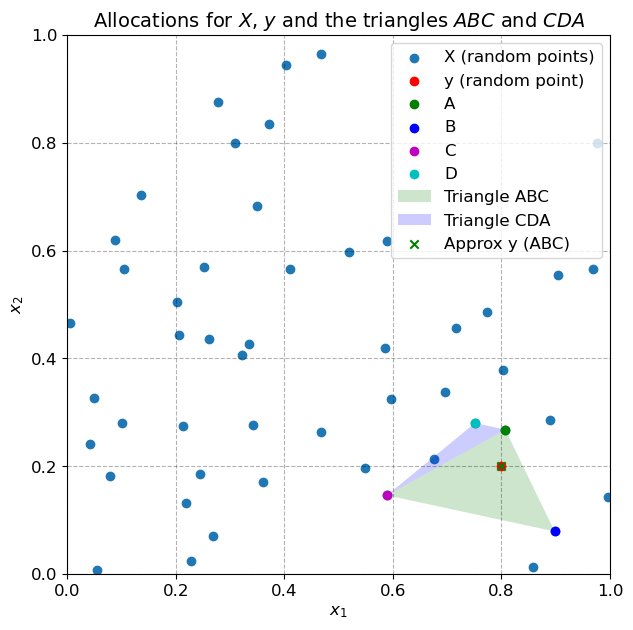

Point y: (0.8, 0.8) is not valid because one or more points A, B, C, D cannot be found.


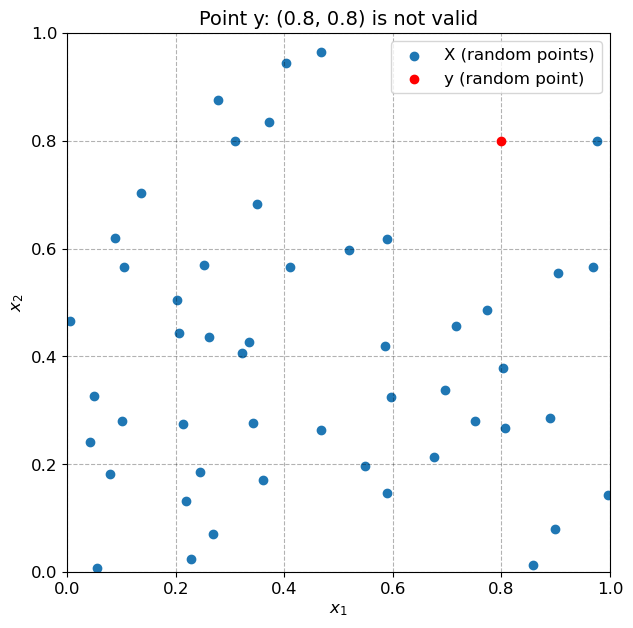

Point y: [0.8 0.2]
Approximation of y (ABC): [0.7999 0.2   ]
Approximation of f(y) (ABC): 0.1587
True value of f(y): 0.16
---


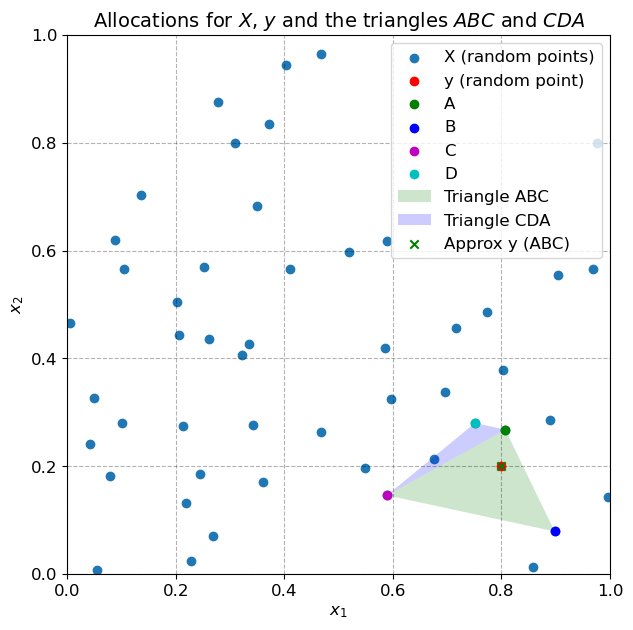

Point y: [0.5 0.5]
Approximation of y (ABC): [0.5001 0.5   ]
Approximation of f(y) (ABC): 0.2513
True value of f(y): 0.25
---


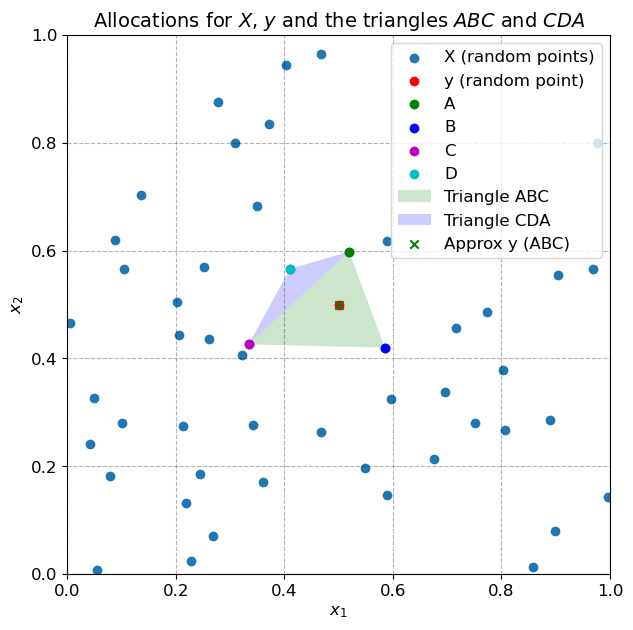

In [18]:
# 
def plot_triangles_and_points(y, y_approx_ABC, y_approx_CDA, A, B, C, D, f_y_approx_ABC, f_y_approx_CDA):
    plt.figure(figsize=(7, 7))
    plt.scatter(problem.X[:, 0], problem.X[:, 1], label='X (random points)')
    plt.scatter(y[0], y[1], color='r', label='y (random point)', zorder=5)
    plt.scatter(A[0], A[1], color='g', label='A', zorder=5)
    plt.scatter(B[0], B[1], color='b', label='B', zorder=5)
    plt.scatter(C[0], C[1], color='m', label='C', zorder=5)
    plt.scatter(D[0], D[1], color='c', label='D', zorder=5)

    plt.fill([A[0], B[0], C[0]], [A[1], B[1], C[1]], 'green', alpha=0.2, label='Triangle ABC')
    plt.fill([C[0], D[0], A[0]], [C[1], D[1], A[1]], 'blue', alpha=0.2, label='Triangle CDA')

    if not np.isnan(f_y_approx_ABC):
        plt.scatter(y_approx_ABC[0], y_approx_ABC[1], color='g', marker='x', label='Approx y (ABC)', zorder=5)

    if not np.isnan(f_y_approx_CDA):
        plt.scatter(y_approx_CDA[0], y_approx_CDA[1], color='b', marker='x', label='Approx y (CDA)', zorder=5)

    plt.xlabel('$x_1$', fontsize=12)
    plt.ylabel('$x_2$', fontsize=12)
    plt.legend()
    plt.title('Allocations for $X$, $y$ and the triangles $ABC$ and $CDA$', fontsize=14)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.grid(True)
    plt.show()

# Iterate over each point in Y and plot the results
for y in Y:
    problem.y = np.round(np.array(y), 3)  # Set y to the current point and round it
    try:
        A = problem.find_A()
        B = problem.find_B()
        C = problem.find_C()
        D = problem.find_D()
    except ValueError:
        print(f"Point y: {y} is not valid because one or more points A, B, C, D cannot be found.")
        # Still plot the points to show why it fails
        plt.figure(figsize=(7, 7))
        plt.scatter(problem.X[:, 0], problem.X[:, 1], label='X (random points)')
        plt.scatter(y[0], y[1], color='r', label='y (random point)', zorder=5)
        plt.xlabel('$x_1$', fontsize=12)
        plt.ylabel('$x_2$', fontsize=12)
        plt.legend()
        plt.title(f'Point y: {y} is not valid', fontsize=14)
        plt.xlim(0, 1)
        plt.ylim(0, 1)
        plt.grid(True)
        plt.show()
        continue

    # Compute the values of f at points A, B, C, and D
    f_A = f(A)
    f_B = f(B)
    f_C = f(C)
    f_D = f(D)

    # Compute the barycentric coordinates of y with respect to triangles ABC and CDA
    r_ABC = problem.barycentric_coordinates(problem.y, A, B, C)
    r_CDA = problem.barycentric_coordinates(problem.y, C, D, A)

    # Determine which triangle y is inside and compute the approximation of f(y)
    if problem.is_inside_triangle(r_ABC):
        f_y_approx_ABC = r_ABC[0] * f_A + r_ABC[1] * f_B + r_ABC[2] * f_C
        y_approx_ABC = r_ABC[0] * A + r_ABC[1] * B + r_ABC[2] * C
    else:
        f_y_approx_ABC = np.nan
        y_approx_ABC = np.nan

    if problem.is_inside_triangle(r_CDA):
        f_y_approx_CDA = r_CDA[0] * f_C + r_CDA[1] * f_D + r_CDA[2] * f_A
        y_approx_CDA = r_CDA[0] * C + r_CDA[1] * D + r_CDA[2] * A
    else:
        f_y_approx_CDA = np.nan
        y_approx_CDA = np.nan

    # Compute the true value of f(y)
    f_y_true = f(problem.y)

    # Round results to three decimal places
    f_y_approx_ABC = np.round(f_y_approx_ABC, 4)
    f_y_approx_CDA = np.round(f_y_approx_CDA, 4)
    f_y_true = np.round(f_y_true, 4)
    y_approx_ABC = np.round(y_approx_ABC, 4)
    y_approx_CDA = np.round(y_approx_CDA, 4)
    true_y = np.round(problem.y, 4)

    # Print the results for the current y
    print(f"Point y: {true_y}")
    if not np.isnan(f_y_approx_ABC):
        print(f"Approximation of y (ABC): {y_approx_ABC}")
        print(f"Approximation of f(y) (ABC): {f_y_approx_ABC}")
    if not np.isnan(f_y_approx_CDA):
        print(f"Approximation of y (CDA): {y_approx_CDA}")
        print(f"Approximation of f(y) (CDA): {f_y_approx_CDA}")
    print(f"True value of f(y): {f_y_true}")
    print(f"---")

    # Plot the results for the current y
    plot_triangles_and_points(problem.y, y_approx_ABC, y_approx_CDA, A, B, C, D, f_y_approx_ABC, f_y_approx_CDA)
